In [1]:
import torch
import torch.optim as optim
from byol_pytorch import BYOL
from torchvision import models
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import glob
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda:1


In [4]:
filenameToPILImage = lambda x: Image.open(x)
class OfficeDataset(Dataset):
    def __init__(self, csv_path, data_dir, ex_encoder=None, ex_decoder=None):
        
        self.data_dir = data_dir
        self.data_df = pd.read_csv(csv_path).set_index("id")
        label_unique = self.data_df.label.unique()

        if ex_encoder is not None:
            self.label_encoder = ex_encoder
        else:
            self.label_encoder = {label_unique[i] : i for i in range(len(label_unique))}
        if ex_decoder is not None:
            self.label_decoder = ex_decoder
        else:
            self.label_decoder = {i : label_unique[i] for i in range(len(label_unique))}

        self.transform = transforms.Compose([
            filenameToPILImage,
            transforms.ToTensor(),
            transforms.Resize((128,128)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __getitem__(self, index):
        path = self.data_df.loc[index, "filename"]
        label = self.data_df.loc[index, "label"]
        image = self.transform(os.path.join(self.data_dir, path))
        return image, self.label_encoder[label]

    def __len__(self):
        return len(self.data_df)
    
    def encoder(self):
        return self.label_encoder
    
    def decoder(self):
        return self.label_decoder

In [5]:
# mini_dataset = OfficeDataset('hw4_data/mini/train.csv', 'hw4_data/mini/train')
# mini_loader = DataLoader(mini_dataset, batch_size=100)

In [6]:
train_dataset = OfficeDataset('hw4_data/office/train.csv', 'hw4_data/office/train')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = OfficeDataset('hw4_data/office/val.csv',
                            'hw4_data/office/val',
                            ex_encoder=train_dataset.encoder(),
                            ex_decoder=train_dataset.decoder())
val_loader = DataLoader(val_dataset, batch_size=4)

In [7]:
def train(model, epoch):
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    correct = 0

    for ep in range(epoch):
        model.train()  # Important: set training mode
        correct = 0
        train_loss = 0
        total = 0
        for i, (data, target) in enumerate(tqdm(train_loader)):            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)
            train_loss += loss.item()

        acc_, loss_ = 100. * correct / total, train_loss / total

        train_acc_his.append(acc_)
        train_loss_his.append(loss_)

        print(f'Epoch:{ep}\tAcc:{acc_:.0f}\tLoss:{loss_:.4f}')

        val(model, ep) 
        
        scheduler.step()


In [8]:
def val(model, ep):
# def val(model):
    criterion = nn.CrossEntropyLoss()
    model.eval()  # Important: set evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): # This will free the GPU memory used for back-prop
        for data, target in tqdm(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)

            pred = output.argmax(dim=1) # get the index of the max log-probability
            correct += pred.eq(target).sum().item()
            total += data.size(0)
            val_loss += criterion(output, target).item() # sum up batch loss

    acc_, loss_ = 100. *correct / total,  val_loss / total
    val_acc_his.append(acc_)
    val_loss_his.append(loss_)
    
    print(f'Val set: Average loss: {loss_:.4f}, Accuracy: {correct}/{total} ({acc_:.0f}%)\n')
    # torch.save(model.state_dict(), f'./resnet50_fc/_{ep}_{acc_:.0f}.pt')
    

In [9]:
def plot_result():
    plt.plot(train_acc_his)
    plt.plot(val_acc_his)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left') 
    plt.show()
    
    plt.plot(train_loss_his)
    plt.plot(val_loss_his)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left') 
    plt.show()

In [10]:
model = models.resnet50()
# model.load_state_dict(torch.load('hw4_data/pretrain_model_SL.pt'))
# model.load_state_dict(torch.load('99_improved-net.pt'))

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
# set_parameter_requires_grad(model, feature_extracting=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 65)
)
# model.load_state_dict(torch.load('resnet50/_27_32.pt'))

model.to(device)

# params_to_update = model.parameters()
# print("Params to learn:")
# for name,param in model.named_parameters():
#     if param.requires_grad == True:
#         print("\t",name)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
train_acc_his, train_loss_his = [], []
val_acc_his, val_loss_his = [], []
train(model, 40)

100%|██████████| 62/62 [01:46<00:00,  1.71s/it]


Epoch:0	Acc:4	Loss:0.0648


100%|██████████| 102/102 [00:11<00:00,  8.65it/s]


Val set: Average loss: 1.0146, Accuracy: 22/406 (5%)



100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Epoch:1	Acc:8	Loss:0.0607


100%|██████████| 102/102 [00:12<00:00,  8.07it/s]


Val set: Average loss: 0.9946, Accuracy: 40/406 (10%)



100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Epoch:2	Acc:13	Loss:0.0562


100%|██████████| 102/102 [00:12<00:00,  8.12it/s]


Val set: Average loss: 0.9277, Accuracy: 58/406 (14%)



100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch:3	Acc:18	Loss:0.0527


100%|██████████| 102/102 [00:12<00:00,  8.49it/s]


Val set: Average loss: 0.9165, Accuracy: 49/406 (12%)



100%|██████████| 62/62 [01:43<00:00,  1.66s/it]


Epoch:4	Acc:23	Loss:0.0489


100%|██████████| 102/102 [00:12<00:00,  8.46it/s]


Val set: Average loss: 0.8695, Accuracy: 73/406 (18%)



100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch:5	Acc:28	Loss:0.0452


100%|██████████| 102/102 [00:11<00:00,  8.58it/s]


Val set: Average loss: 0.8483, Accuracy: 78/406 (19%)



100%|██████████| 62/62 [01:40<00:00,  1.62s/it]


Epoch:6	Acc:34	Loss:0.0405


100%|██████████| 102/102 [00:12<00:00,  8.39it/s]


Val set: Average loss: 0.8250, Accuracy: 89/406 (22%)



100%|██████████| 62/62 [01:41<00:00,  1.63s/it]


Epoch:7	Acc:41	Loss:0.0359


100%|██████████| 102/102 [00:11<00:00,  8.71it/s]


Val set: Average loss: 0.8304, Accuracy: 83/406 (20%)



100%|██████████| 62/62 [01:42<00:00,  1.66s/it]


Epoch:8	Acc:50	Loss:0.0306


100%|██████████| 102/102 [00:11<00:00,  8.68it/s]


Val set: Average loss: 0.8216, Accuracy: 87/406 (21%)



100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


Epoch:9	Acc:64	Loss:0.0233


100%|██████████| 102/102 [00:11<00:00,  8.65it/s]


Val set: Average loss: 0.8498, Accuracy: 89/406 (22%)



100%|██████████| 62/62 [01:39<00:00,  1.60s/it]


Epoch:10	Acc:74	Loss:0.0175


100%|██████████| 102/102 [00:11<00:00,  8.76it/s]


Val set: Average loss: 0.8934, Accuracy: 89/406 (22%)



100%|██████████| 62/62 [01:40<00:00,  1.63s/it]


Epoch:11	Acc:88	Loss:0.0105


100%|██████████| 102/102 [00:11<00:00,  8.76it/s]


Val set: Average loss: 0.8686, Accuracy: 89/406 (22%)



100%|██████████| 62/62 [01:39<00:00,  1.60s/it]


Epoch:12	Acc:95	Loss:0.0056


100%|██████████| 102/102 [00:11<00:00,  8.83it/s]


Val set: Average loss: 0.8459, Accuracy: 101/406 (25%)



100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


Epoch:13	Acc:99	Loss:0.0025


100%|██████████| 102/102 [00:11<00:00,  8.87it/s]


Val set: Average loss: 0.8246, Accuracy: 108/406 (27%)



100%|██████████| 62/62 [01:39<00:00,  1.60s/it]


Epoch:14	Acc:99	Loss:0.0011


100%|██████████| 102/102 [00:11<00:00,  8.55it/s]


Val set: Average loss: 0.7891, Accuracy: 120/406 (30%)



100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch:15	Acc:99	Loss:0.0007


100%|██████████| 102/102 [00:11<00:00,  8.51it/s]


Val set: Average loss: 0.7861, Accuracy: 114/406 (28%)



100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch:16	Acc:99	Loss:0.0005


100%|██████████| 102/102 [00:11<00:00,  8.53it/s]


Val set: Average loss: 0.7842, Accuracy: 117/406 (29%)



100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch:17	Acc:99	Loss:0.0004


100%|██████████| 102/102 [00:12<00:00,  8.26it/s]


Val set: Average loss: 0.7811, Accuracy: 117/406 (29%)



100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


Epoch:18	Acc:99	Loss:0.0003


100%|██████████| 102/102 [00:11<00:00,  8.84it/s]


Val set: Average loss: 0.7867, Accuracy: 117/406 (29%)



100%|██████████| 62/62 [01:39<00:00,  1.60s/it]


Epoch:19	Acc:99	Loss:0.0003


100%|██████████| 102/102 [00:11<00:00,  8.75it/s]


Val set: Average loss: 0.7876, Accuracy: 125/406 (31%)



100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch:20	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:12<00:00,  8.37it/s]


Val set: Average loss: 0.7872, Accuracy: 125/406 (31%)



100%|██████████| 62/62 [01:40<00:00,  1.62s/it]


Epoch:21	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:11<00:00,  8.73it/s]


Val set: Average loss: 0.7839, Accuracy: 124/406 (31%)



100%|██████████| 62/62 [01:40<00:00,  1.62s/it]


Epoch:22	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:12<00:00,  8.47it/s]


Val set: Average loss: 0.7853, Accuracy: 127/406 (31%)



100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


Epoch:23	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:11<00:00,  8.75it/s]


Val set: Average loss: 0.7856, Accuracy: 121/406 (30%)



100%|██████████| 62/62 [01:41<00:00,  1.63s/it]


Epoch:24	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:12<00:00,  8.36it/s]


Val set: Average loss: 0.7923, Accuracy: 124/406 (31%)



100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


Epoch:25	Acc:99	Loss:0.0002


100%|██████████| 102/102 [00:11<00:00,  9.03it/s]


Val set: Average loss: 0.7899, Accuracy: 123/406 (30%)



100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch:26	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:11<00:00,  8.53it/s]


Val set: Average loss: 0.7865, Accuracy: 122/406 (30%)



100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


Epoch:27	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:12<00:00,  8.43it/s]


Val set: Average loss: 0.7910, Accuracy: 118/406 (29%)



100%|██████████| 62/62 [01:41<00:00,  1.63s/it]


Epoch:28	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:12<00:00,  8.46it/s]


Val set: Average loss: 0.7890, Accuracy: 124/406 (31%)



100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


Epoch:29	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:11<00:00,  8.56it/s]


Val set: Average loss: 0.7866, Accuracy: 121/406 (30%)



100%|██████████| 62/62 [01:42<00:00,  1.66s/it]


Epoch:30	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:12<00:00,  8.37it/s]


Val set: Average loss: 0.7897, Accuracy: 125/406 (31%)



100%|██████████| 62/62 [01:40<00:00,  1.62s/it]


Epoch:31	Acc:99	Loss:0.0002


100%|██████████| 102/102 [00:11<00:00,  8.53it/s]


Val set: Average loss: 0.7902, Accuracy: 119/406 (29%)



100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch:32	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:11<00:00,  8.74it/s]


Val set: Average loss: 0.7902, Accuracy: 118/406 (29%)



100%|██████████| 62/62 [01:38<00:00,  1.60s/it]


Epoch:33	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:11<00:00,  8.76it/s]


Val set: Average loss: 0.7895, Accuracy: 123/406 (30%)



100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch:34	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:11<00:00,  8.70it/s]


Val set: Average loss: 0.7890, Accuracy: 120/406 (30%)



100%|██████████| 62/62 [01:44<00:00,  1.69s/it]


Epoch:35	Acc:100	Loss:0.0002


100%|██████████| 102/102 [00:12<00:00,  8.37it/s]


Val set: Average loss: 0.7856, Accuracy: 122/406 (30%)



  8%|▊         | 5/62 [00:08<01:41,  1.79s/it]


KeyboardInterrupt: 

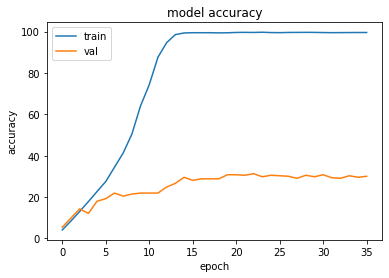

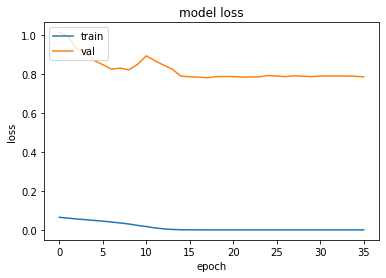

In [13]:
plot_result()